# Reglerentwurf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display, Image, Latex
from scipy.integrate import solve_ivp

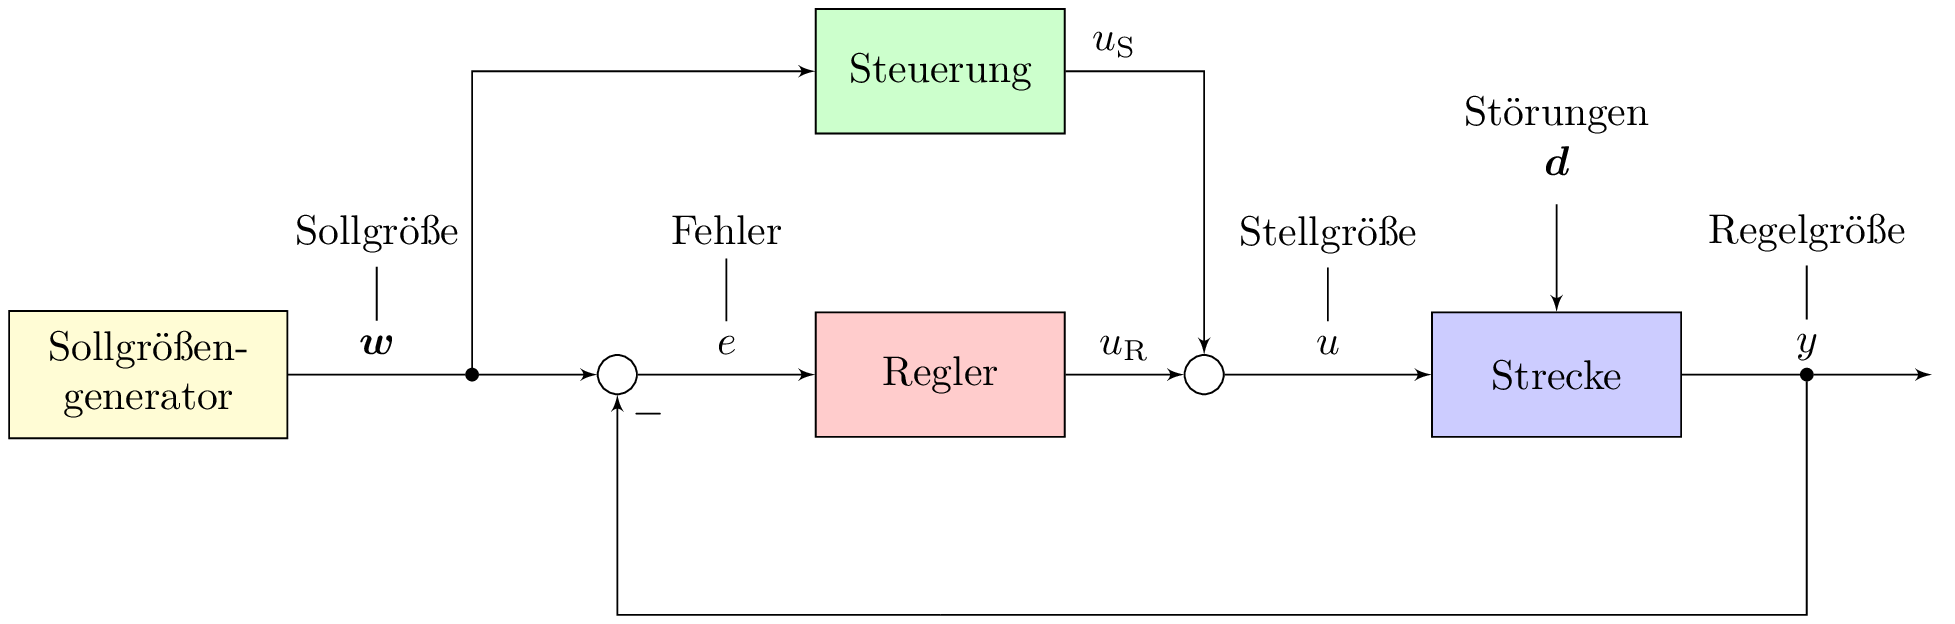

In [2]:
imag = Image("../images/feedback.png", width=600)
display(imag)

Ziel ist der Entwurf eines Reglers auf Basis des linearisierten Modells des Zweitanksystems
\begin{align*}
    T_1 T_2 \ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = \tilde{u}_{\mathrm{A}}(t)
\end{align*}

### 1. Eintragen der notwendigen Systemparameter

In [3]:
# Ruhelagen
buA = 9
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588

### 2. Bestimmung der Reglerparameter mittels Betragsoptimums

In [4]:
# with modelled parameters
KpPhy = T1Phy / (2 * KPhy * T2Phy)
KiPhy = KpPhy / T1Phy

# with parameters of pt2 measurement
KpMessung = T1Messung / (2 * KMessung * T2Messung)
KiMessung = KpMessung / T1Messung

# print results
dp = 5 # decimal places
d = {   'KP': [round(KpPhy, dp), round(KpMessung,dp)],
        'KI': [round(KiPhy,dp), round(KiMessung,dp)],}
print ("{:<5} {:<11} {:<9}".format(' ','modelling','PT2'))
for name, values in d.items():
    s1, s2 = values
    print ("{:<5} {:<11} {:<9}".format(name, s1, s2))

      modelling   PT2      
KP    1.71479     1.36915  
KI    0.04961     0.11606  


### 3. Vergleich der Regelung an den Modellen

__Simulation__

Definition nichtlineares Modell

In [5]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [6]:
def linSys(t, x, uA, T1Sys, T2Sys, KSys, buA):
    A = np.array([[0, 1],
                  [-1 / (T1Sys * T2Sys), -(T1Sys + T2Sys) / (T1Sys * T2Sys)]])
    B = np.array([[0],
                  [KSys / (T1Sys * T2Sys)]])
    return A.dot(x) + B.dot(np.array([uA - buA]))

Definition Regler

In [8]:
class ReglerPID:
    def __init__(self, setPoint, P, I, D, outMin, outMax, sampleTime):
        self.P = P
        self.I = I
        self.D = D
        self.setPoint = setPoint
        self.outMin = outMin
        self.outMax = outMax
        self.sampleTime = sampleTime
        self.e = 0
        self.int = 0

    def regel(self, curValue):
        e = self.setPoint - curValue

        intStep = (e + self.e) * self.sampleTime
        diffStep = (e - self.e) / self.sampleTime

        out = (self.P * e +
               self.I * (self.int + intStep) / 2.0 +
               self.D * diffStep)

        if out < self.outMin:
            out = self.outMin
        elif out > self.outMax:
            out = self.outMax
        else:
            self.int += intStep

        self.e = e

        return out

    def reset(self):
        self.e = 0
        self.int = 0

Simulation mit theoretischen Streckenparametern

In [14]:
timeDom = np.linspace(0, 1000, 10001)
z0 = [0, 0]
z2Soll = 0.15

zReglerPhyLin = np.zeros((2, len(timeDom)))
zReglerMessungLin = np.zeros((2, len(timeDom)))
uReglerPhyLin = np.zeros((len(timeDom),))
uReglerMessungLin = np.zeros((len(timeDom),))

zReglerPhyNonLin = np.zeros((2, len(timeDom)))
zReglerMessungNonLin = np.zeros((2, len(timeDom)))
uReglerPhyNonLin = np.zeros((len(timeDom),))
uReglerMessungNonLin = np.zeros((len(timeDom),))

zReglerPhyLin[:, 0] = z0 - np.array([bz2Phy, 0])
zReglerMessungLin[:, 0] = z0 - np.array([bz2Messung, 0])

reglerPhyLin = ReglerPID(z2Soll - bz2Phy, KpPhy, KiPhy, 0, -buA, 12 - buA, timeDom[1])
reglerMessungLin = ReglerPID(z2Soll - bz2Messung, KpMessung, KiMessung, 0, -buA, 12 - buA, timeDom[1])

reglerPhyNonLin = ReglerPID(z2Soll, KpPhy, KiPhy, 0, -buA, 12 - buA, timeDom[1])
reglerMessungNonLin = ReglerPID(z2Soll, KpMessung, KiMessung, 0, - buA, 12 - buA, timeDom[1])

reglerPhyLin.reset()
reglerMessungLin.reset()

reglerPhyNonLin.reset()
reglerMessungNonLin.reset()

                   
for idx, _t in enumerate(timeDom[1:]):
        x0PhyLin = zReglerPhyLin[:, idx]
        x0MessungLin = zReglerMessungLin[:, idx]
        uReglerPhyLin[idx] = reglerPhyLin.regel(x0PhyLin[0]) + buA
        uReglerMessungLin[idx] = reglerMessungLin.regel(x0MessungLin[0]) + buA
        
        resPhyLin = solve_ivp(linSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0PhyLin,
                        args=(uReglerPhyLin[idx], T1Phy, T2Phy, KPhy, buA))
        zReglerPhyLin[0, idx + 1] = resPhyLin.y.T[-1, 0]
        zReglerPhyLin[1, idx + 1] = resPhyLin.y.T[-1, 1]

        resMessungLin = solve_ivp(linSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0MessungLin,
                        args=(uReglerMessungLin[idx], T1Phy, T2Phy, KPhy, buA))
        zReglerMessungLin[0, idx + 1] = resMessungLin.y.T[-1, 0]
        zReglerMessungLin[1, idx + 1] = resMessungLin.y.T[-1, 1]
        
        x0PhyNonLin = zReglerPhyNonLin[:, idx]
        x0MessungNonLin = zReglerMessungNonLin[:, idx]
        uReglerPhyNonLin[idx] = reglerPhyNonLin.regel(x0PhyNonLin[0]) + buA
        uReglerMessungNonLin[idx] = reglerMessungNonLin.regel(x0MessungNonLin[0]) + buA
        
        resPhyNonLin = solve_ivp(nonLinSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0PhyNonLin,
                        args=(uReglerPhyNonLin[idx],))
        zReglerPhyNonLin[0, idx + 1] = resPhyNonLin.y.T[-1, 0]
        zReglerPhyNonLin[1, idx + 1] = resPhyNonLin.y.T[-1, 1]

        resMessungNonLin = solve_ivp(nonLinSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0MessungNonLin,
                        args=(uReglerMessungNonLin[idx],))
        zReglerMessungNonLin[0, idx + 1] = resMessungNonLin.y.T[-1, 0]
        zReglerMessungNonLin[1, idx + 1] = resMessungNonLin.y.T[-1, 1]

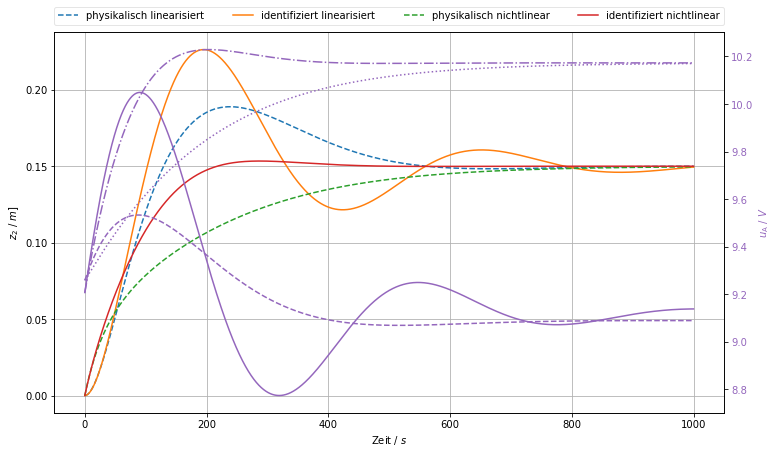

In [15]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(timeDom, zReglerPhyLin[0, :] + bz2Phy, linestyle='dashed', label='physikalisch linearisiert')
axes10.plot(timeDom, zReglerMessungLin[0, :] + bz2Messung, label='identifiziert linearisiert')
axes10.plot(timeDom, zReglerPhyNonLin[0, :], linestyle='dashed', label='physikalisch nichtlinear')
axes10.plot(timeDom, zReglerMessungNonLin[0, :], label='identifiziert nichtlinear')
#axes10.plot(timeDom, resMessung.y[0] + bz2Messung, label=r'identifiziert')


handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes11 = axes10.twinx()

axes11.plot(timeDom[:-1:], uReglerPhyLin[:-1:], linestyle='dashed', color='C4')
axes11.plot(timeDom[:-1:], uReglerMessungLin[:-1:], color='C4')
axes11.plot(timeDom[:-1:], uReglerPhyNonLin[:-1:], linestyle=':', color='C4')
axes11.plot(timeDom[:-1:], uReglerMessungNonLin[:-1:], linestyle='-.', color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ / $m$]')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='C4')
axes10.set_xlabel(r'Zeit / $s$')

axes10.grid()
plt.show()

Simulation mit identifizierten Streckenparametern

In [18]:
timeDom = np.linspace(0, 1000, 10001)
z0 = [0, 0]
z2Soll = 0.15

zReglerPhyLin = np.zeros((2, len(timeDom)))
zReglerMessungLin = np.zeros((2, len(timeDom)))
uReglerPhyLin = np.zeros((len(timeDom),))
uReglerMessungLin = np.zeros((len(timeDom),))

zReglerPhyNonLin = np.zeros((2, len(timeDom)))
zReglerMessungNonLin = np.zeros((2, len(timeDom)))
uReglerPhyNonLin = np.zeros((len(timeDom),))
uReglerMessungNonLin = np.zeros((len(timeDom),))

zReglerPhyLin[:, 0] = z0 - np.array([bz2Phy, 0])
zReglerMessungLin[:, 0] = z0 - np.array([bz2Messung, 0])

reglerPhyLin.reset()
reglerMessungLin.reset()

reglerPhyNonLin.reset()
reglerMessungNonLin.reset()
                   
for idx, _t in enumerate(timeDom[1:]):
        x0PhyLin = zReglerPhyLin[:, idx]
        x0MessungLin = zReglerMessungLin[:, idx]
        uReglerPhyLin[idx] = reglerPhyLin.regel(x0PhyLin[0]) + buA
        uReglerMessungLin[idx] = reglerMessungLin.regel(x0MessungLin[0]) + buA
        
        resPhyLin = solve_ivp(linSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0PhyLin,
                        args=(uReglerPhyLin[idx], T1Messung, T2Messung, KMessung, buA))
        zReglerPhyLin[0, idx + 1] = resPhyLin.y.T[-1, 0]
        zReglerPhyLin[1, idx + 1] = resPhyLin.y.T[-1, 1]

        resMessungLin = solve_ivp(linSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0MessungLin,
                        args=(uReglerMessungLin[idx], T1Messung, T2Messung, KMessung, buA))
        zReglerMessungLin[0, idx + 1] = resMessungLin.y.T[-1, 0]
        zReglerMessungLin[1, idx + 1] = resMessungLin.y.T[-1, 1]
        
        x0PhyNonLin = zReglerPhyNonLin[:, idx]
        x0MessungNonLin = zReglerMessungNonLin[:, idx]
        uReglerPhyNonLin[idx] = reglerPhyNonLin.regel(x0PhyNonLin[0]) + buA
        uReglerMessungNonLin[idx] = reglerMessungNonLin.regel(x0MessungNonLin[0]) + buA
        
        resPhyNonLin = solve_ivp(nonLinSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0PhyNonLin,
                        args=(uReglerPhyNonLin[idx],))
        zReglerPhyNonLin[0, idx + 1] = resPhyNonLin.y.T[-1, 0]
        zReglerPhyNonLin[1, idx + 1] = resPhyNonLin.y.T[-1, 1]

        resMessungNonLin = solve_ivp(nonLinSys,
                        [timeDom[idx], timeDom[idx + 1]],
                        x0MessungNonLin,
                        args=(uReglerMessungNonLin[idx],))
        zReglerMessungNonLin[0, idx + 1] = resMessungNonLin.y.T[-1, 0]
        zReglerMessungNonLin[1, idx + 1] = resMessungNonLin.y.T[-1, 1]

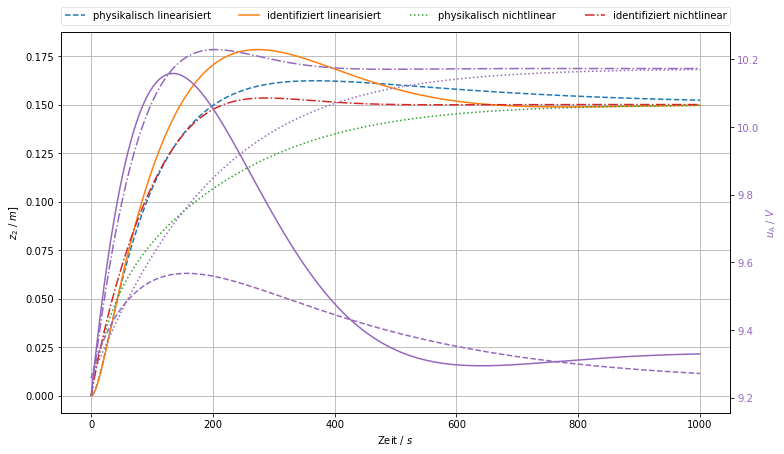

In [19]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(timeDom, zReglerPhyLin[0, :] + bz2Phy, linestyle='dashed', label='physikalisch linearisiert')
axes10.plot(timeDom, zReglerMessungLin[0, :] + bz2Messung, label='identifiziert linearisiert')
axes10.plot(timeDom, zReglerPhyNonLin[0, :], linestyle=':', label='physikalisch nichtlinear')
axes10.plot(timeDom, zReglerMessungNonLin[0, :], linestyle='-.', label='identifiziert nichtlinear')


handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes11 = axes10.twinx()

axes11.plot(timeDom[:-1:], uReglerPhyLin[:-1:], linestyle='dashed', color='C4')
axes11.plot(timeDom[:-1:], uReglerMessungLin[:-1:], color='C4')
axes11.plot(timeDom[:-1:], uReglerPhyNonLin[:-1:], linestyle=':', color='C4')
axes11.plot(timeDom[:-1:], uReglerMessungNonLin[:-1:], linestyle='-.', color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ / $m$]')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='C4')
axes10.set_xlabel(r'Zeit / $s$')

axes10.grid()
plt.show()